In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import pickle

In [21]:
def concatenate_parquet_files(path):
    """
    Concatenate all parquet files in the given directory into a single DataFrame.

    Parameters:
    path (str): The directory containing the parquet files.

    Returns:
    pd.DataFrame: The concatenated DataFrame.
    """
    # List all files in the directory
    files = [f for f in os.listdir(path) if f.endswith('.parquet')]
    
    # Read and concatenate all parquet files
    dataframes = [pd.read_parquet(os.path.join(path, file)) for file in files]
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

In [22]:
path_zee = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/zee_deriv/single'
path_ttbar = '/groups/hep/kinch/data/preprocessed_data/files_for_dual_models/ttbar/single'

data_ttbar = concatenate_parquet_files(path_ttbar)
data_zeederiv = concatenate_parquet_files(path_zee)

print(f'TTbar data shape: {data_ttbar.shape}')
print(f'Zee deriv data shape: {data_zeederiv.shape}')

data_ttbar['ATLAS_E'] = np.sqrt(data_ttbar['el1_pt']**2 * np.cosh(data_ttbar['el1_eta']**2 + data_ttbar['el1_m']**2))
data_zeederiv['ATLAS_E'] = np.sqrt(data_zeederiv['el1_pt']**2 * np.cosh(data_zeederiv['el1_eta']**2 + data_zeederiv['el1_m']**2))

TTbar data shape: (2705661, 78)
Zee deriv data shape: (2077252, 78)


TTbar data shape: (2705661, 78)
Zee deriv data shape: (386770, 78)

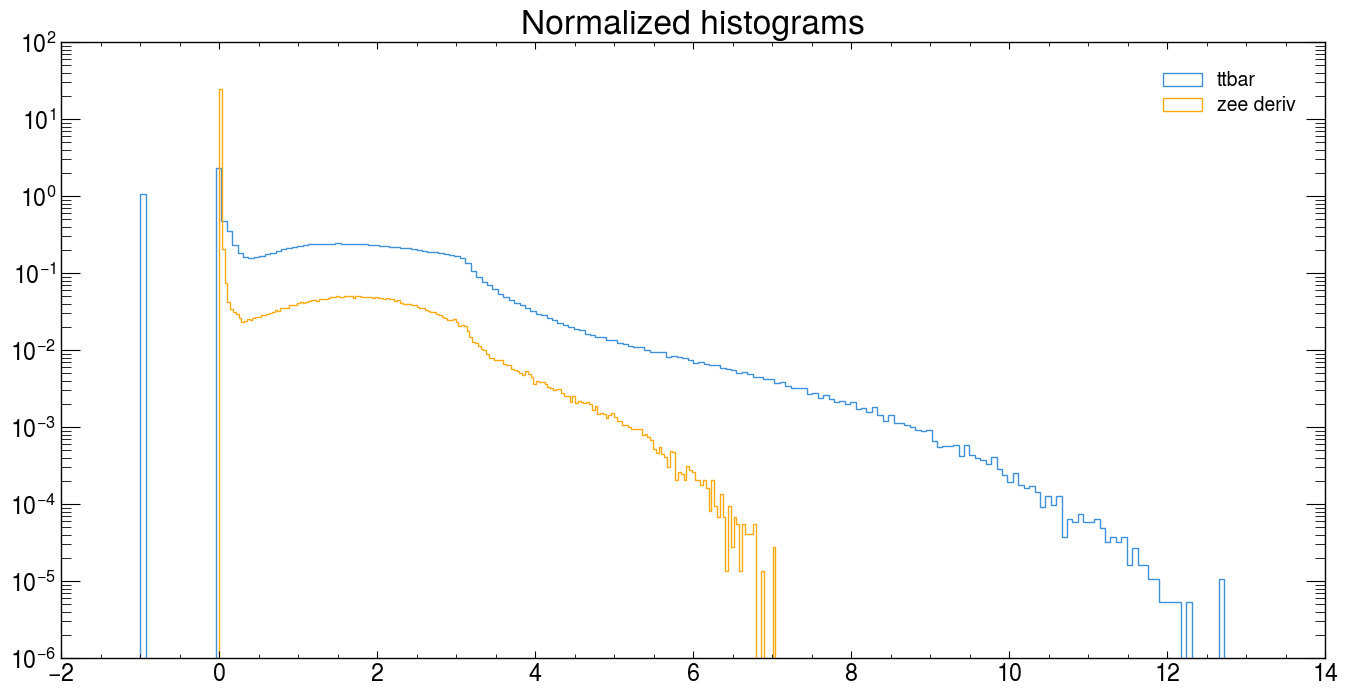

In [23]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(data_ttbar['el1_truth_dR'],histtype='step',density=True,bins=200, label='ttbar')
ax.hist(data_zeederiv['el1_truth_dR'],histtype='step',density=True,bins=200, label='zee deriv')
ax.set_title('Normalized histograms')
ax.set_yscale('log')
ax.legend()

In [24]:
print(len(data_ttbar[data_ttbar['el1_truth_dR']==-1])/len(data_ttbar))

0.07214651059389923


In [25]:
cut_data_ttbar = data_ttbar[data_ttbar['el1_truthType'] == 2]
cut_data_zeederiv = data_zeederiv[data_zeederiv['el1_truthType'] == 2]

print(len(cut_data_ttbar)/len(data_ttbar))
print(len(cut_data_zeederiv)/len(data_zeederiv))


0.10529183072084788
0.8377847271298812


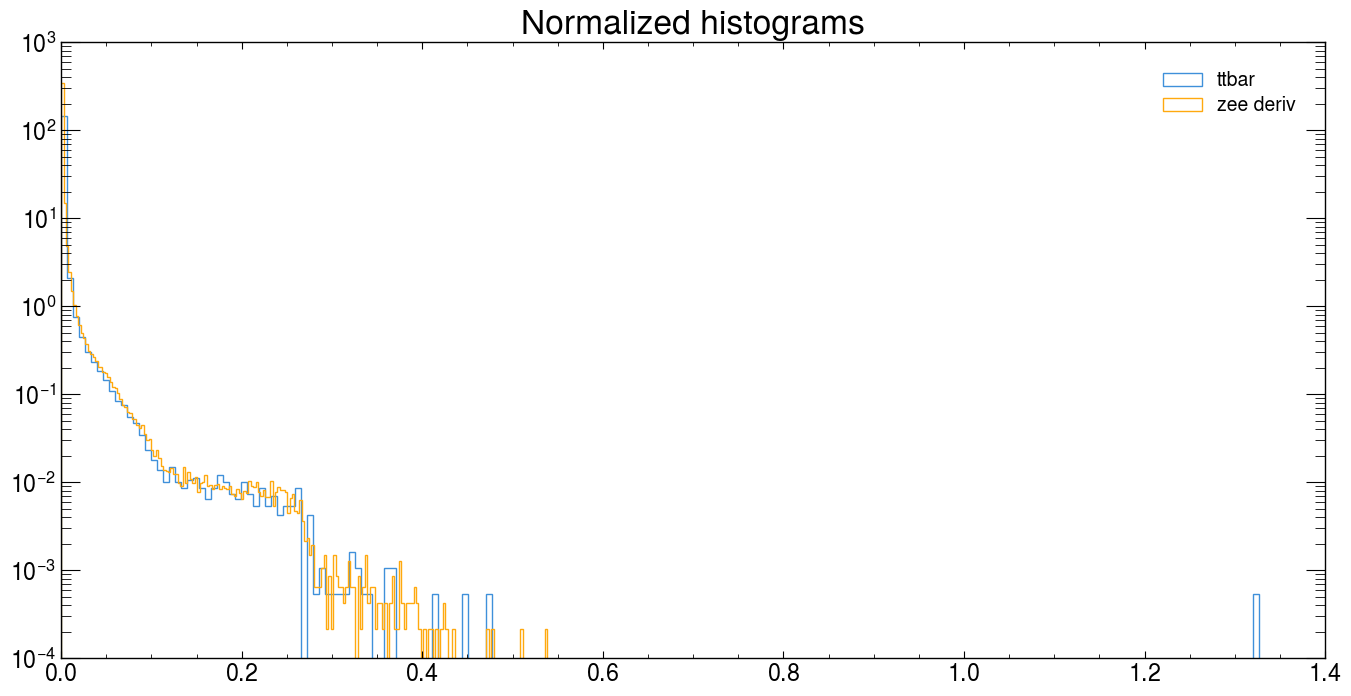

In [26]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(cut_data_ttbar['el1_truth_dR'],histtype='step',density=True,bins=200, label='ttbar')
ax.hist(cut_data_zeederiv['el1_truth_dR'],histtype='step',density=True,bins=200, label='zee deriv')
ax.set_title('Normalized histograms')
ax.set_yscale('log')
ax.legend()

In [27]:
# truth_filter = (0, 0.1)
# cut_data_ttbar = data_ttbar[(data_ttbar['el1_truth_dR'] >= truth_filter[0]) & (data_ttbar['el1_truth_dR'] <= truth_filter[1])]
# cut_data_zeederiv = data_zeederiv[(data_zeederiv['el1_truth_dR'] >= truth_filter[0]) & (data_zeederiv['el1_truth_dR'] <= truth_filter[1])]
# print(len(cut_data_ttbar)/len(data_ttbar))
# print(len(cut_data_zeederiv)/len(data_zeederiv))

In [28]:
print(data_ttbar.columns)

Index(['event_index', 'el1_index', 'runNumber', 'eventNumber', 'eventTrigger',
       'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'el1_pt', 'el1_eta', 'el1_phi', 'el1_m', 'el1_charge', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_LHLoose',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_DFCommonElectronsLHVeryLoose',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsDNN_phf',
       'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
       'el1_GSFTrack_d0', 'el1_GSFTrack_z0', 'el1_GSFTrack_theta',
       'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP', 'el1_GSF_dR',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_GSF_Track_Var2',
       'el1_GSF_Track

5      33313.027344
15    140177.406250
28     34722.859375
Name: el1_truth_E, dtype: float64
5      33553.570312
15    192487.078125
28     32340.638672
Name: ATLAS_E, dtype: float32


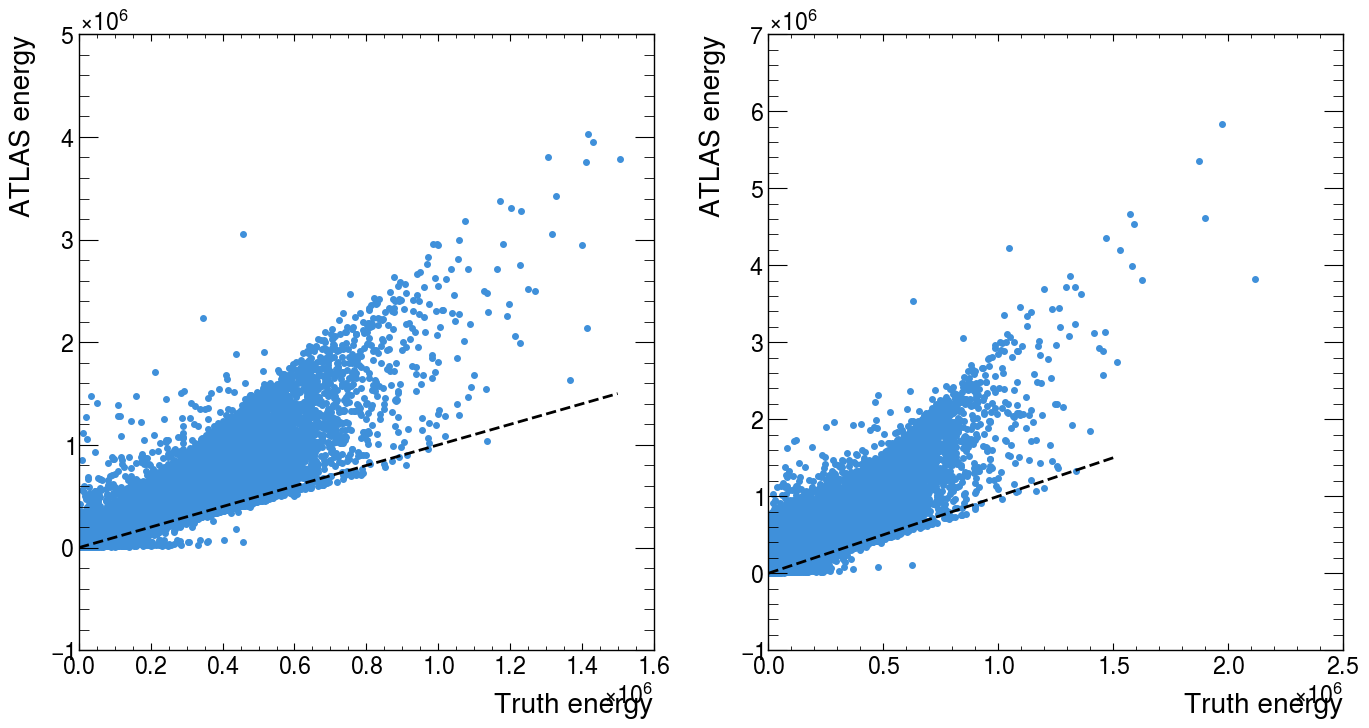

In [29]:
fig, ax = plt.subplots(1,2,figsize = (16, 8))
ax[0].plot(cut_data_ttbar['el1_truth_E'], cut_data_ttbar['ATLAS_E'], '.', label='zee deriv')
ax[0].plot([0, 1.5e6], [0, 1.5e6], 'k--')
ax[1].plot(cut_data_zeederiv['el1_truth_E'],cut_data_zeederiv['ATLAS_E'], '.', label='zee deriv')
ax[1].plot([0, 1.5e6], [0, 1.5e6], 'k--')
ax[0].set_xlabel('Truth energy')
ax[0].set_ylabel('ATLAS energy')
ax[1].set_xlabel('Truth energy')
ax[1].set_ylabel('ATLAS energy')

print(cut_data_ttbar['el1_truth_E'].head(3))
print(cut_data_ttbar['ATLAS_E'].head(3))

In [30]:
param_list = ['el1_eta', 'el1_phi', 'el1_m', 'el1_charge', 'el1_f1',
       'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_LHLoose',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_DFCommonElectronsLHVeryLoose',
       'el1_DFCommonElectronsLHVeryLooseIsEMValue',
       'el1_DFCommonElectronsDNN_pel', 'el1_DFCommonElectronsDNN_pcf',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsDNN_phf',
       'el1_DFCommonElectronsDNN_ple', 'el1_DFCommonElectronsDNN_plh',
       'el1_GSFTrack_d0', 'el1_GSFTrack_z0', 'el1_GSFTrack_theta',
       'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP', 'el1_GSF_dR',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el1_GSF_Track_Var2',
       'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4', 'el1_ptvarcone20',
       'el1_topoetcone20', 'el1_topoetcone40',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_core57cellsEnergyCorrection', 'el1_topoetcone20ptCorrection',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500','el1_InDetTrack_d0', 'el1_InDetTrack_z0',
       'el1_InDetTrack_theta', 'el1_InDetTrack_phi', 'el1_InDetTrack_covdiag0',
       'el1_InDetTrack_covdiag1', 'el1_InDetTrack_covdiag2',
       'el1_InDetTrack_covdiag3', 'el1_InDetTrack_covdiag4', 'el1_InDet_dR' ]

In [31]:
data = pd.concat([cut_data_zeederiv, cut_data_ttbar]).reset_index(drop=True)

print('Number of duplicate rows in data:', (data[['eventNumber','el1_index']]).duplicated().sum())


print(((data['eventNumber'] % 4)).value_counts())
# train = data[data['eventNumber'] % 4 != 0]
# test = data[data['eventNumber'] % 4 == 0]


train, test = train_test_split(data, test_size=0.25, random_state=1)

# train = data.sample(frac=0.75, random_state=13)
# test = data.drop(train.index)

print('train:', len(train), len(train)/(len(train) + len(test)))
print('test:', len(test), len(test)/(len(train) + len(test)))
print('ratio:', len(test)/len(train))

X_train = train[param_list]
y_train = train['el1_truth_E']

Number of duplicate rows in data: 1228
eventNumber
3    507257
2    506349
0    505928
1    505640
Name: count, dtype: int64
train: 1518880 0.7499997531076342
test: 506294 0.2500002468923658
ratio: 0.33333377225323924



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 4436.329637434264
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 4428.178589270532
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 4499.432625471217
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 4480.384693334731
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 4593.898112102319
 ..........................................................

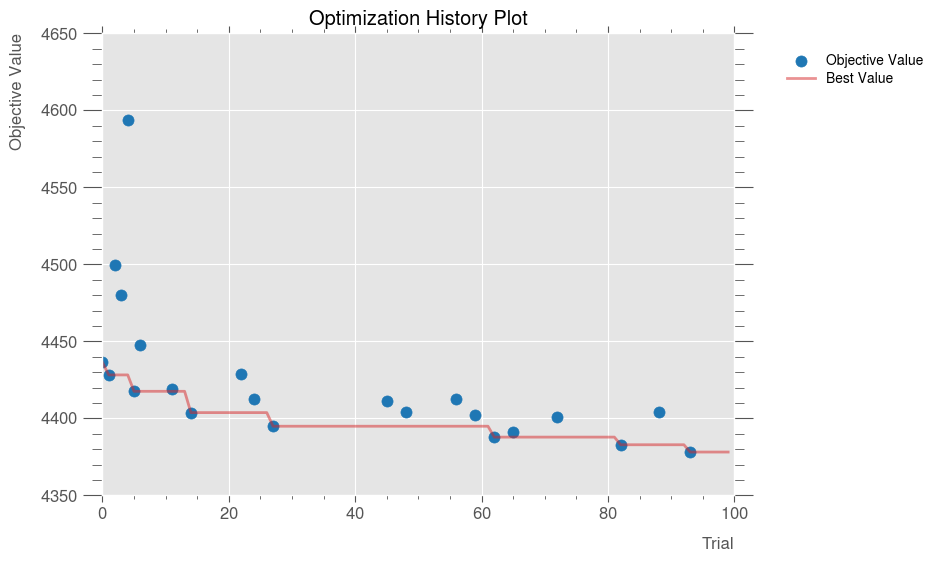

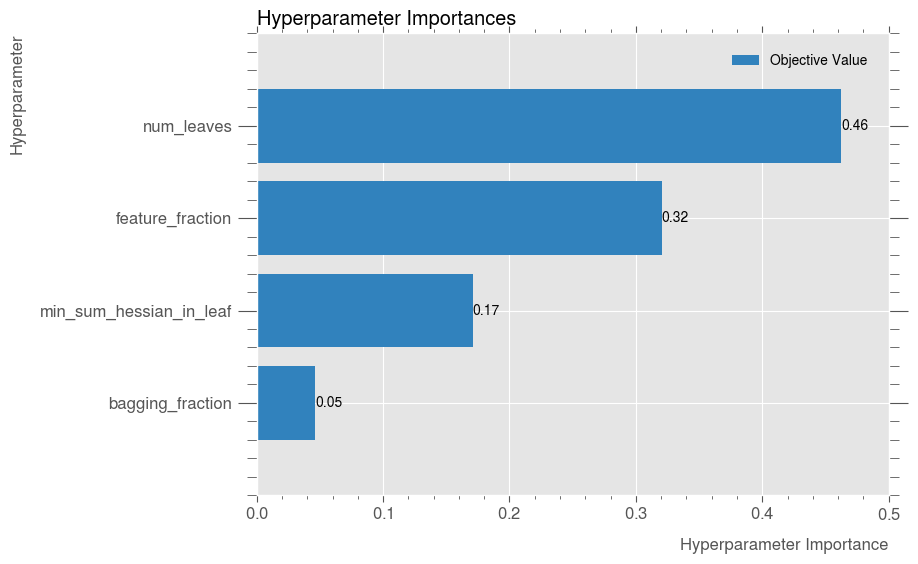

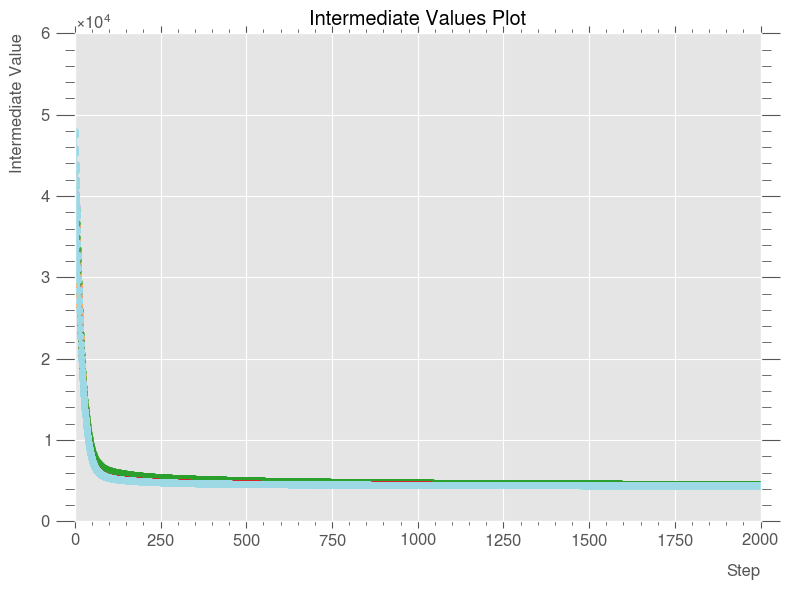

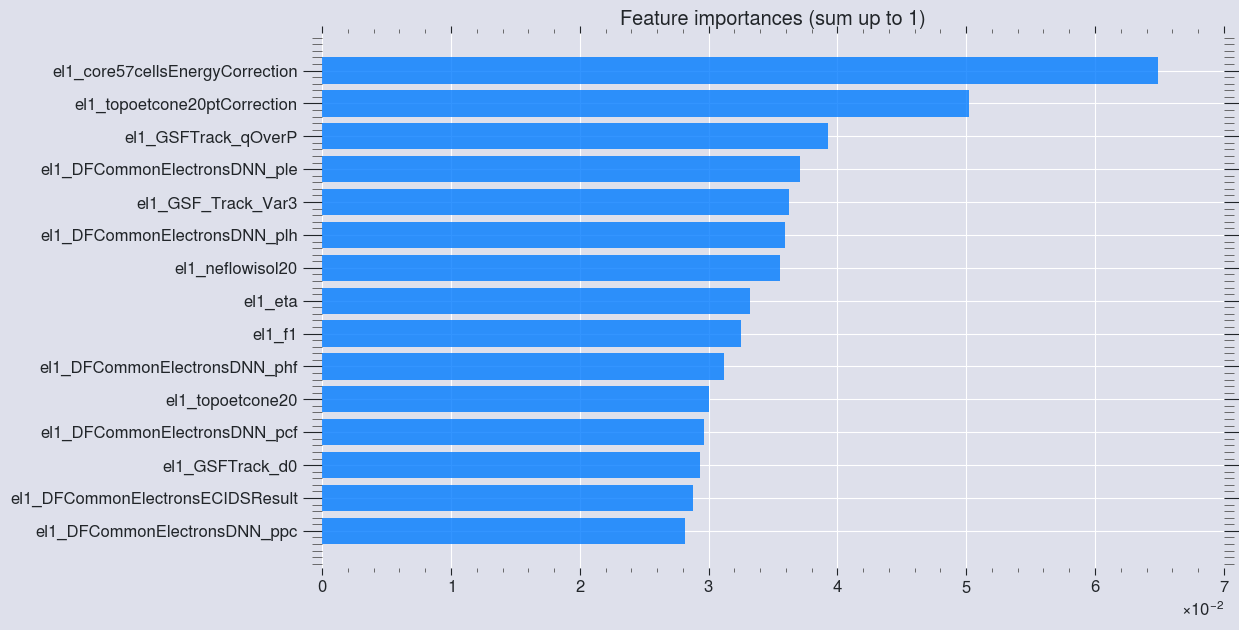


     . Optuna hyperparameters optimization finished
     .. Best trial number:93    |     mae:           4378.0954994504245
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 45 min 5.899 sec

   - Fitting optimized model with the following params:
learning_rate                    : 0.05
num_leaves                       : 254
feature_fraction                 : 0.9020429227898122
bagging_fraction                 : 0.956952534288376
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l1
num_threads                      : 38
min_sum_hessian_in_leaf          : 7.116202890479089
num_iterations                   : 1997


In [32]:
tuner = RapidGBMTuner(metric='mae', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)
tuner.fit(X_train, y_train)

tuner.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())

no


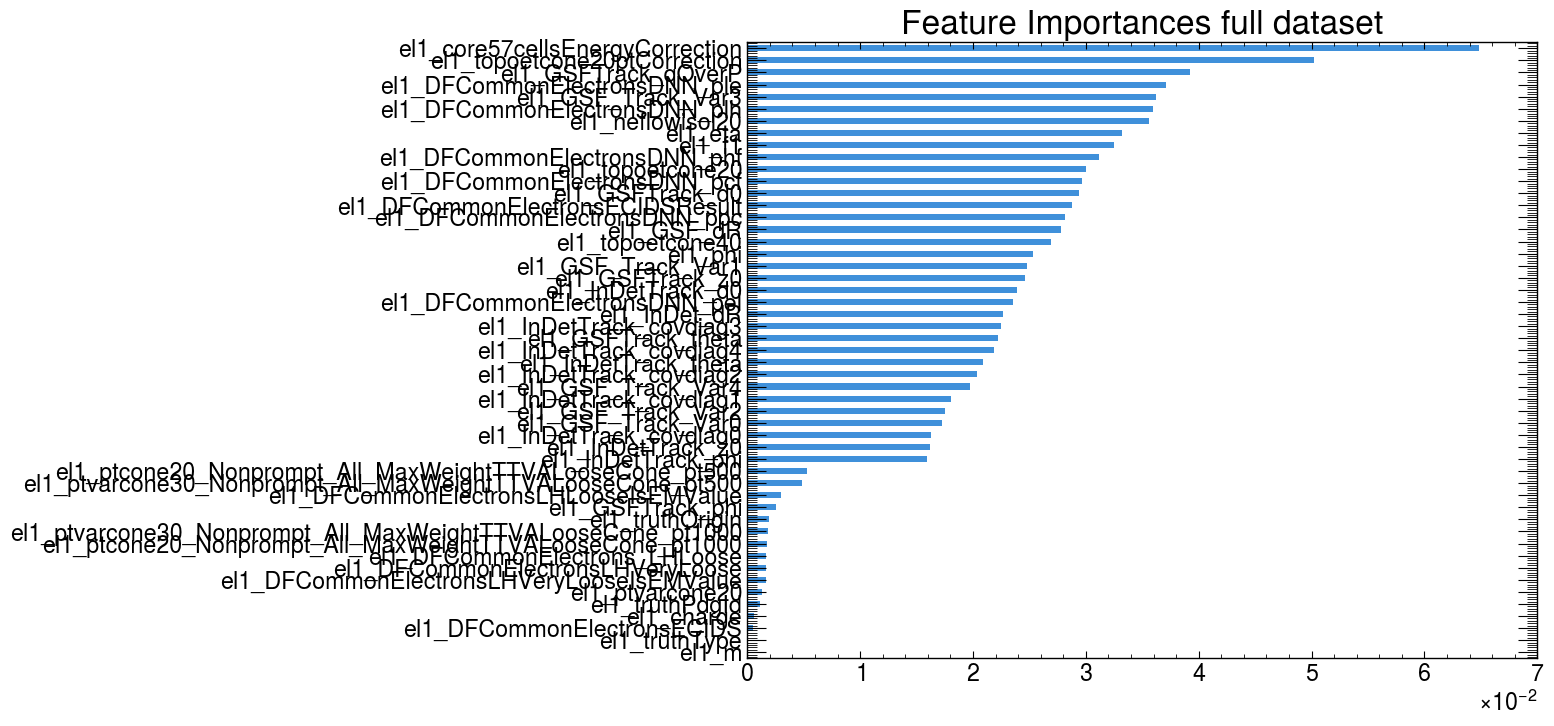

In [33]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Feature Importances full dataset')
tuner.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

Text(0.5, 1.0, 'full dataset')

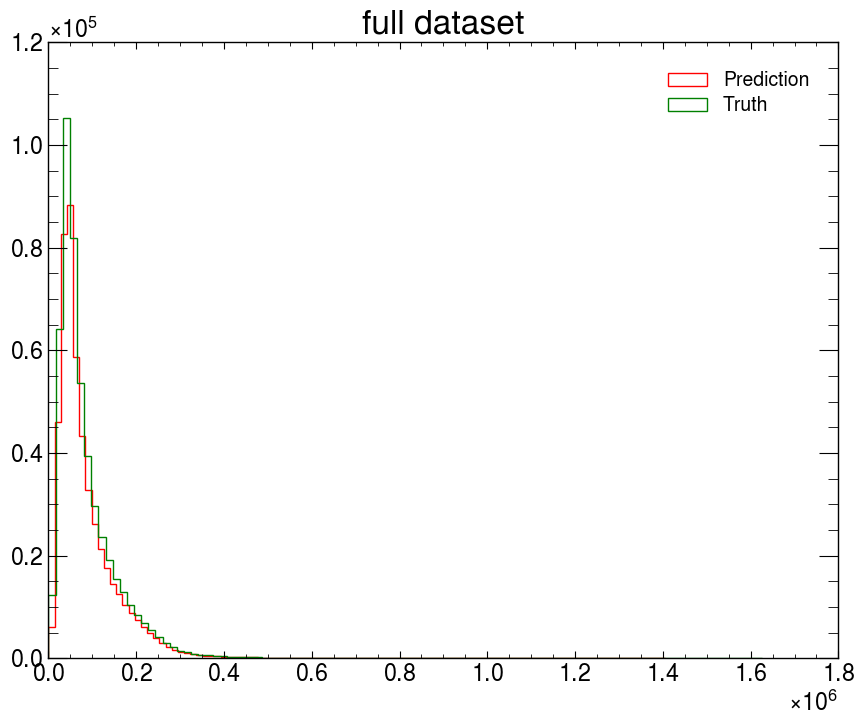

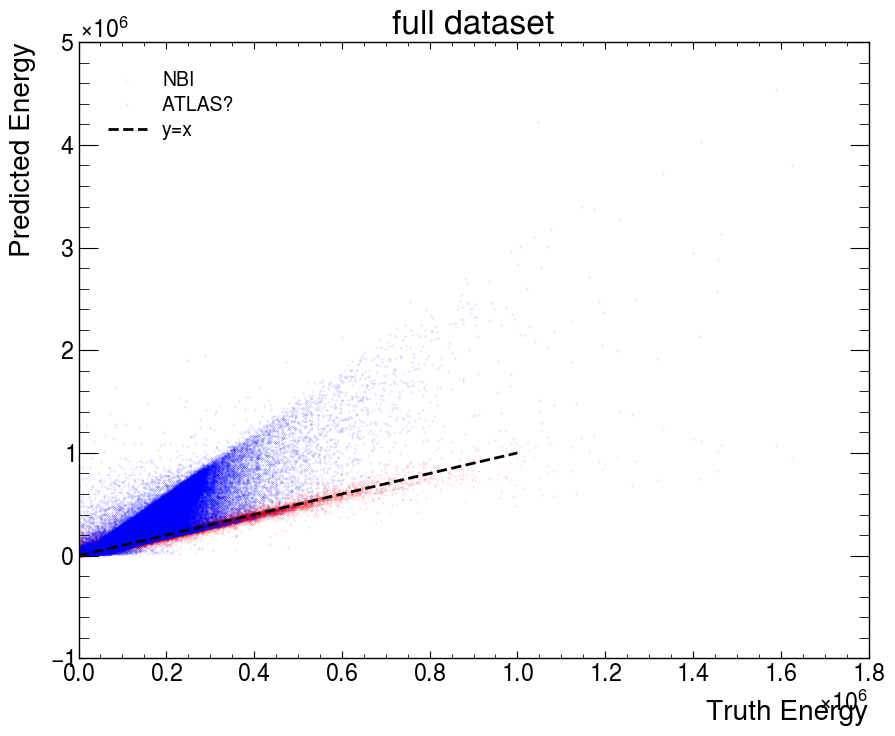

In [34]:
prediction = tuner.predict(test[param_list])

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(prediction, bins=100, histtype='step', label='Prediction', color='red')
ax.hist(test['el1_truth_E'], bins=100, histtype='step', label='Truth', color='green')
# ax.hist(test['el1_pt'], bins=100, histtype='step', label='pt')
ax.legend()
ax.set_title('full dataset')


fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test['el1_truth_E'], prediction, '.',color='red',label='NBI', alpha=0.5, ms=0.3)
ax.plot(test['el1_truth_E'], test['ATLAS_E'],'.', color='blue',label='ATLAS?', alpha=0.5, ms=0.3)
ax.plot([0, 1e6], [0, 1e6], 'k--', label='y=x')
ax.legend()
ax.set_xlabel('Truth Energy')
ax.set_ylabel('Predicted Energy')
ax.set_title('full dataset')



no


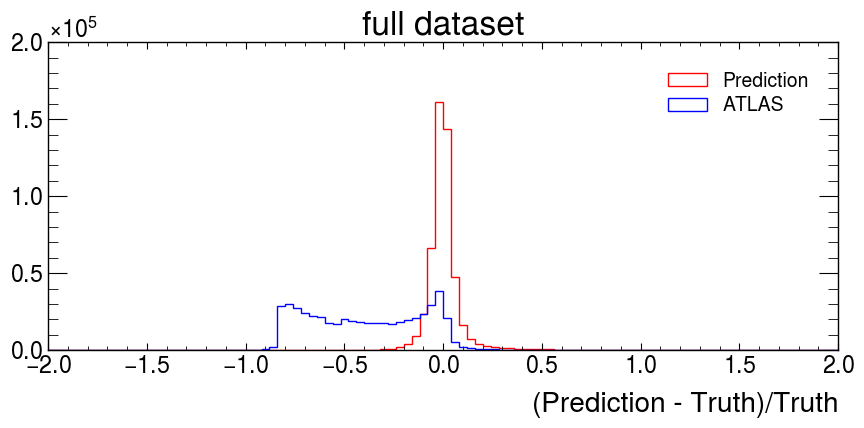

In [35]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist((prediction - test['el1_truth_E'])/test['el1_truth_E'],range=(-2,2), bins=100, histtype='step', label='Prediction', color='red')
ax.hist((test['el1_pt'] - test['el1_truth_E'])/test['el1_truth_E'],range=(-2,2), bins=100, histtype='step', label='ATLAS', color='blue')
ax.legend()
ax.set_xlabel('(Prediction - Truth)/Truth')
ax.set_title('full dataset')

print('no')

In [36]:
print(tuner.feature_importances.sort_values().index[10:-1])

Index(['el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el1_truthOrigin', 'el1_GSFTrack_phi',
       'el1_DFCommonElectronsLHLooseIsEMValue',
       'el1_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
       'el1_InDetTrack_phi', 'el1_InDetTrack_z0', 'el1_InDetTrack_covdiag0',
       'el1_GSF_Track_Var0', 'el1_GSF_Track_Var2', 'el1_InDetTrack_covdiag1',
       'el1_GSF_Track_Var4', 'el1_InDetTrack_covdiag2', 'el1_InDetTrack_theta',
       'el1_InDetTrack_covdiag4', 'el1_GSFTrack_theta',
       'el1_InDetTrack_covdiag3', 'el1_InDet_dR',
       'el1_DFCommonElectronsDNN_pel', 'el1_InDetTrack_d0', 'el1_GSFTrack_z0',
       'el1_GSF_Track_Var1', 'el1_phi', 'el1_topoetcone40', 'el1_GSF_dR',
       'el1_DFCommonElectronsDNN_ppc', 'el1_DFCommonElectronsECIDSResult',
       'el1_GSFTrack_d0', 'el1_DFCommonElectronsDNN_pcf', 'el1_topoetcone20',
       'el1_DFCommonElectronsDNN_phf', 'el1_f1', 'el1_


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 10487.296891676617
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 10387.10006673881
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 10797.777799933323
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 10727.950337778118
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 10923.387610598806
 ......................................................

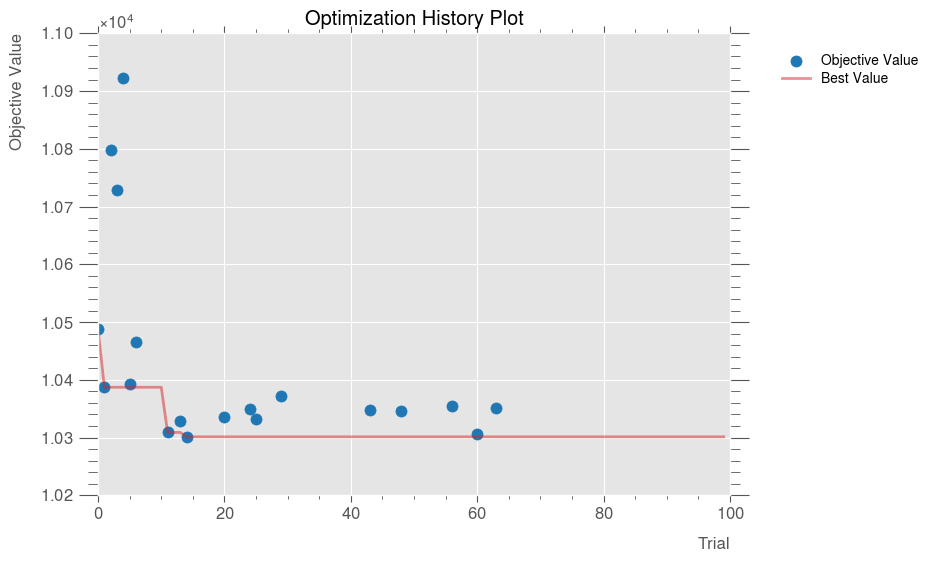

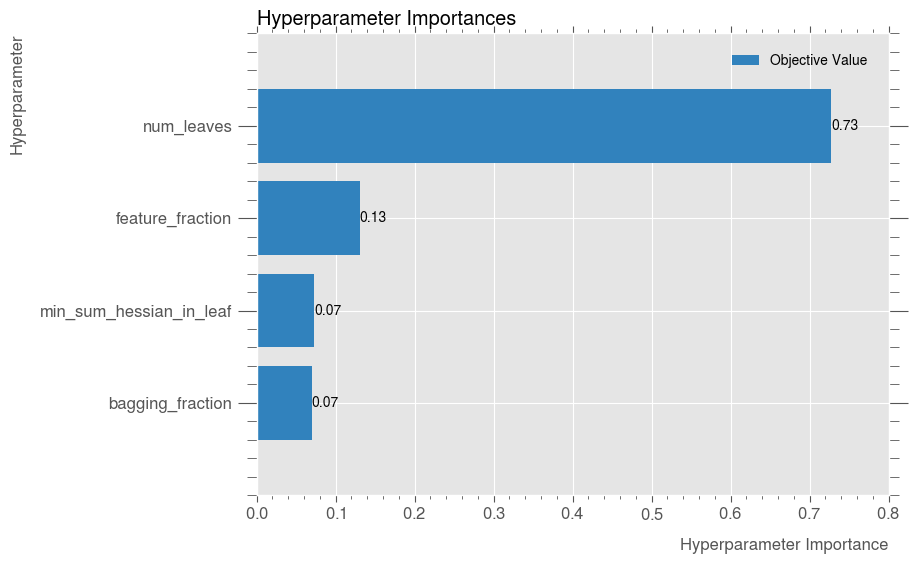

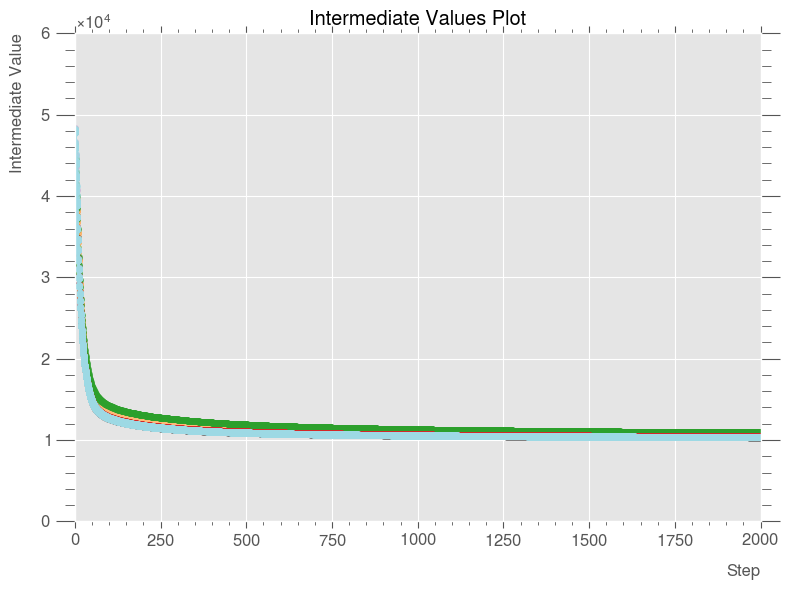

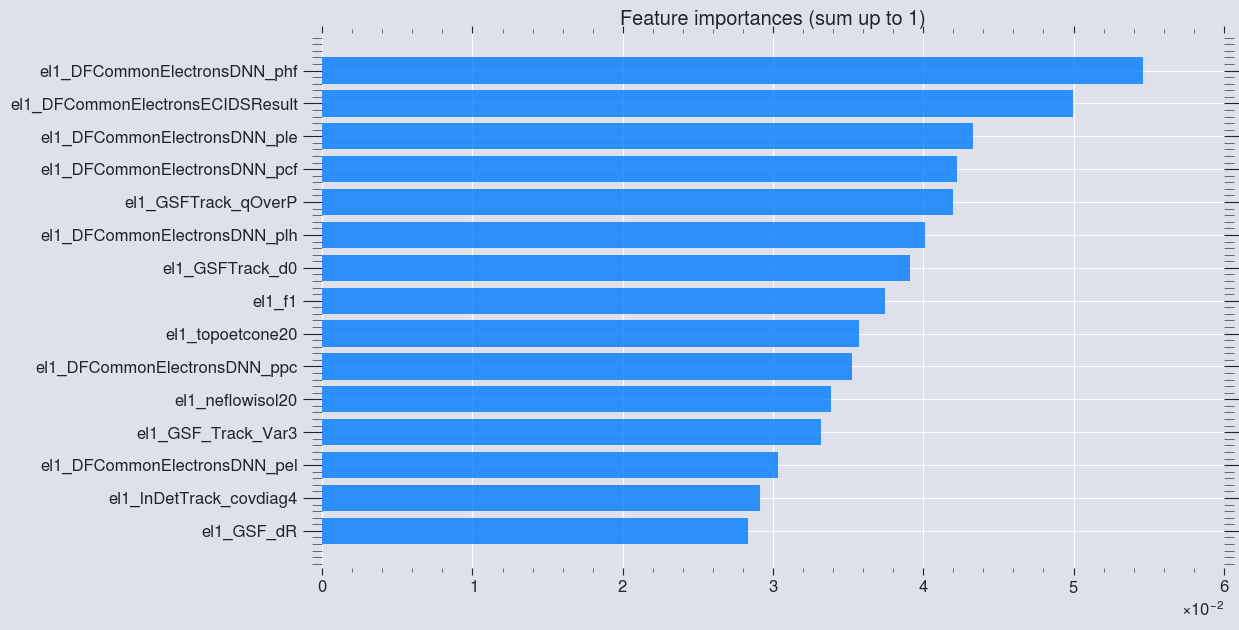


     . Optuna hyperparameters optimization finished
     .. Best trial number:14    |     mae:           10301.301902347142
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 41 min 20.641 sec

   - Fitting optimized model with the following params:
learning_rate                    : 0.05
num_leaves                       : 253
feature_fraction                 : 0.9132068345516368
bagging_fraction                 : 0.8006163247905491
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l1
num_threads                      : 38
min_sum_hessian_in_leaf          : 6.308341937594717
num_iterations                   : 2000


In [37]:
reduced_param_list = tuner.feature_importances.sort_values().index[10:-2]

X_train = train[reduced_param_list]
y_train = train['el1_truth_E']

tuner1 = RapidGBMTuner(metric='mae', trials=100, refit=True, verbosity=1, visualization=True, seed=414243)
tuner1.fit(X_train, y_train)

tuner1.fit_optimized(X_train.to_numpy(), y_train.squeeze().to_numpy())

no


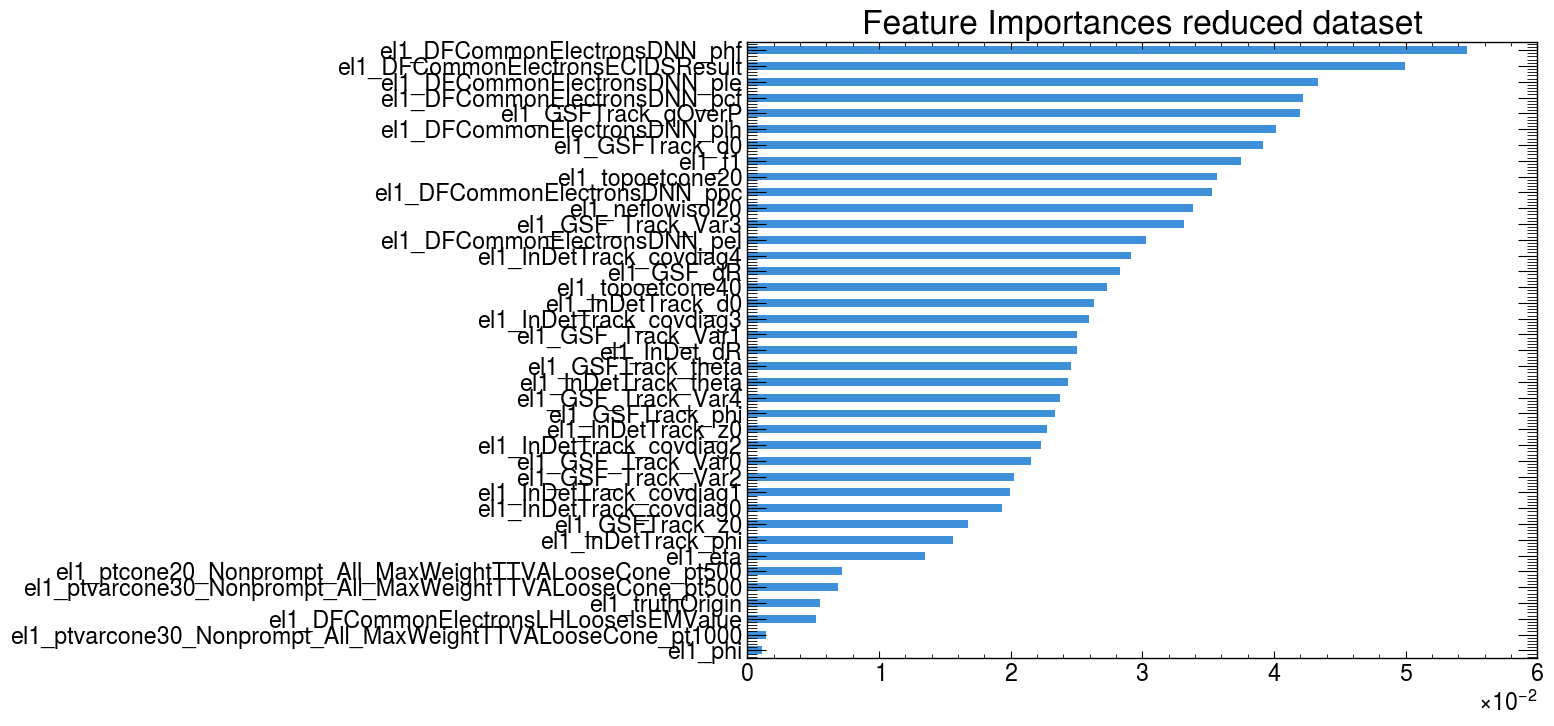

In [38]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Feature Importances reduced dataset')
tuner1.feature_importances.sort_values().plot(ax=ax,kind='barh')
# ax.set_xticklabels(tuner.feature_importances.sort_values().index, rotation=45)
print('no')

no


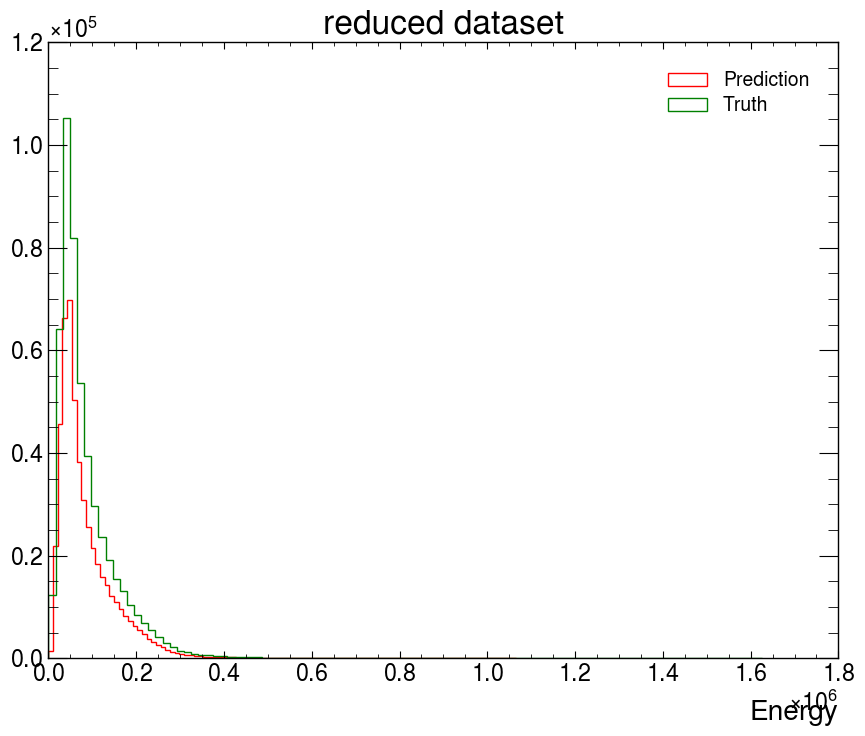

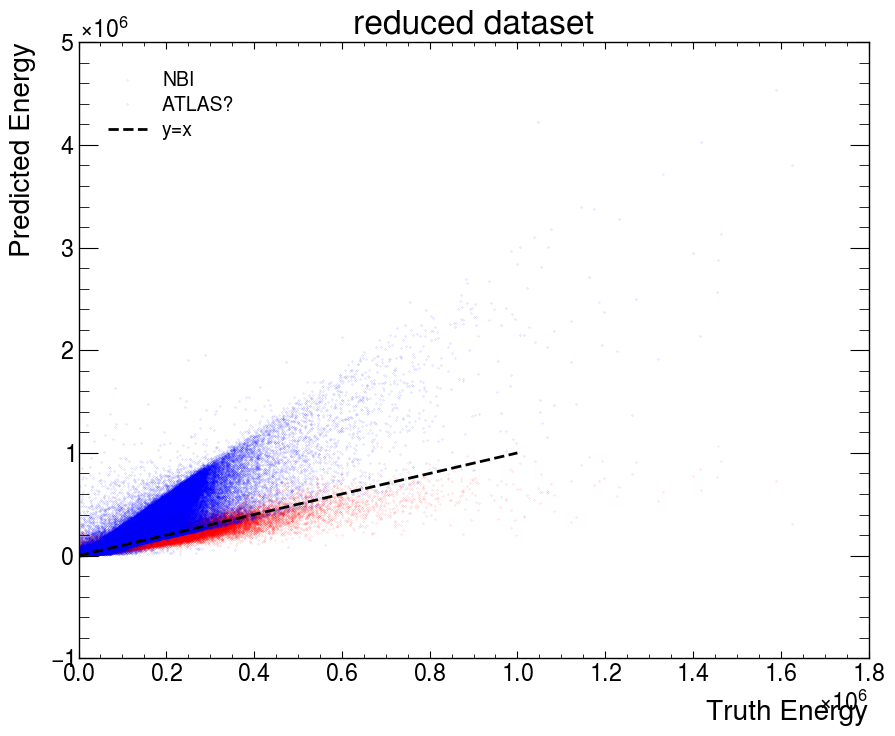

In [39]:
prediction_red = tuner1.predict(test[reduced_param_list])

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(prediction_red, bins=100, histtype='step', label='Prediction', color='red')
ax.hist(test['el1_truth_E'], bins=100, histtype='step', label='Truth', color='green')
# ax.hist(test['el1_pt'], bins=100, histtype='step', label='pt')
ax.legend()
ax.set_title('reduced dataset')
ax.set_xlabel('Energy')


fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test['el1_truth_E'], prediction_red, '.',color='red',label='NBI', alpha=0.5, ms=0.3)
ax.plot(test['el1_truth_E'], test['ATLAS_E'],'.', color='blue',label='ATLAS?', alpha=0.5, ms=0.3)
ax.plot([0, 1e6], [0, 1e6], 'k--', label='y=x')
ax.legend()
ax.set_xlabel('Truth Energy')
ax.set_ylabel('Predicted Energy')
ax.set_title('reduced dataset')

print('no')

no


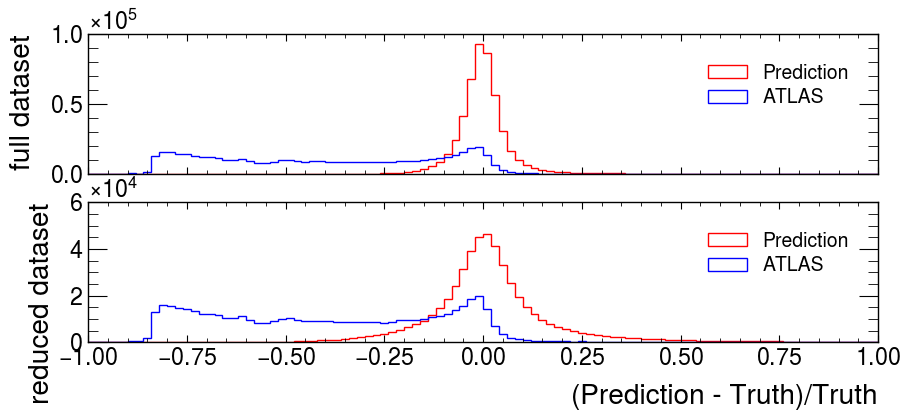

In [40]:

fig, ax = plt.subplots(2,1,figsize=(10, 4))


ax[0].hist((prediction - test['el1_truth_E'])/test['el1_truth_E'],range=(-1,1), bins=100, histtype='step', label='Prediction', color='red')
ax[0].hist((test['el1_pt'] - test['el1_truth_E'])/test['el1_truth_E'],range=(-1,1), bins=100, histtype='step', label='ATLAS', color='blue')
ax[0].set_ylabel('full dataset')
ax[0].set_xticklabels([])
ax[0].legend()

ax[1].hist((prediction_red - test['el1_truth_E'])/test['el1_truth_E'],range=(-1,1), bins=100, histtype='step', label='Prediction', color='red')
ax[1].hist((test['el1_pt'] - test['el1_truth_E'])/test['el1_truth_E'],range=(-1,1), bins=100, histtype='step', label='ATLAS', color='blue')
ax[1].legend()
ax[1].set_xlabel('(Prediction - Truth)/Truth')
ax[1].set_ylabel('reduced dataset')

print('no')

In [43]:
# save model
import pickle
with open('E_model_BDT_ttbar_Zeederiv_1Oct.pkl', 'wb') as file: #bdt_MC_HZg_mumu_1s02bkg_100ep_23Sept
    pickle.dump(tuner, file)
with open('E_model_BDT_ttbar_Zeederiv_variables_1Oct_variables.pkl', 'wb') as fp:
    pickle.dump(param_list, fp)

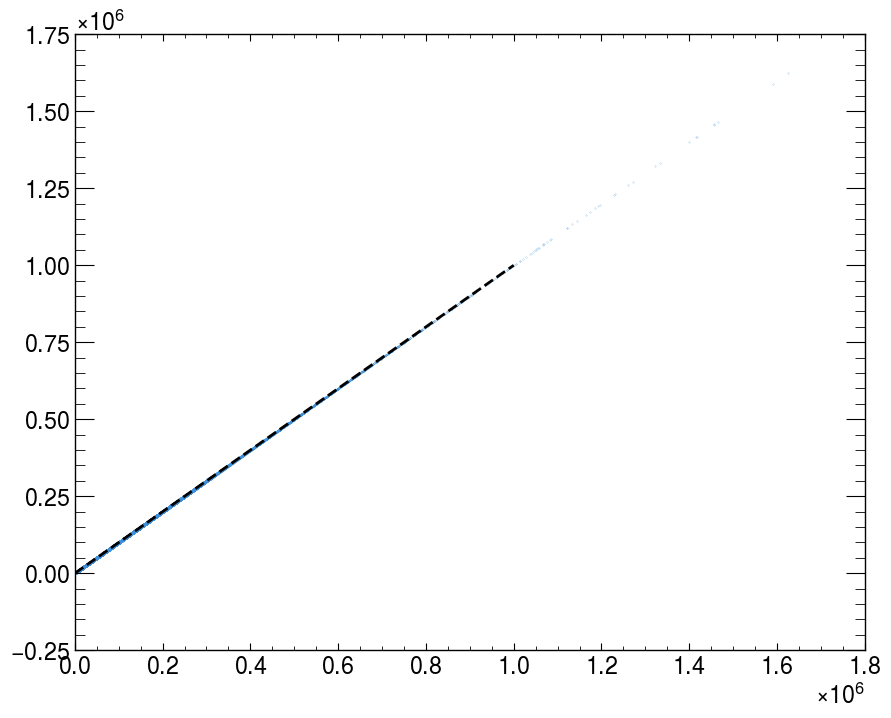

In [42]:
p = np.sqrt(test['el1_truth_px']**2 + test['el1_truth_py']**2 + test['el1_truth_pz']**2)
e = test['el1_truth_E']

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(e, p, '.', ms=0.3)
ax.plot([0, 1e6], [0, 1e6], 'k--', label='y=x')